# Library

In [1]:
import random
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew, entropy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore') 

# Data

In [2]:
imgression = pd.read_csv('ingression-20230924.csv')
imbalance = pd.read_csv('imbalance-20230924.csv')
normal = pd.read_csv('normal-20230924.csv')

# Preprocessing. . .

In [96]:
reimgression = imgression['A'].rolling(window=4).mean()
reimbalance = imbalance['A'].rolling(window=4).mean()
renormal = normal['A'].rolling(window=4).mean()

reimgression = reimgression.dropna()
reimbalance = reimbalance.dropna()
renormal = renormal.dropna()

print("언밸런스 데이터 개수:", len(reimbalance))
print("이물질 데이터 개수:", len(reimgression))
print("정상 데이터 개수:", len(renormal))


# def split_and_average(df, segment_size=4, column_name='A'):
#     averages = []
#     for i in tqdm(range(0, len(df), segment_size)):
#         segment = df[column_name].iloc[i:i+segment_size].values
#         if len(segment) == segment_size:
#             avg = np.ptp(segment)
#             averages.append(avg)
    
#     # 리스트를 데이터프레임으로 변환
#     return pd.DataFrame(averages, columns=[f"A"])

# # 예제 사용법
# renormal = split_and_average(normal, 4, 'A')
# reimgression = split_and_average(imgression, 4, 'A')
# reimbalance = split_and_average(imbalance, 4, 'A')

언밸런스 데이터 개수: 1769469
이물질 데이터 개수: 1591293
정상 데이터 개수: 19234813


In [97]:
# def ae_without_fft(df, frequency):
#     extracted_data = []
#     for i in range(0, len(df), frequency):
#         segment = df.iloc[i:i+frequency]
#         if len(segment) == frequency:
#             extracted_data.append(segment.values)  # FFT 없이 값을 바로 추출
#     return pd.DataFrame(extracted_data)

# num_of_learning = 500000
# frequency = 100

# normal_ae = ae_without_fft(renormal[:num_of_learning], frequency)
# normal_ae = np.array(normal_ae).reshape(-1,1,frequency)
# normal_ae.shape

def ae_with_fft(df, frequency):
    extracted_features = []
    for i in range(0, len(df), frequency):
        segment = df.iloc[i:i+frequency]
        if len(segment) == frequency:
            # FFT 적용
            fft_values = np.fft.fft(segment)
            
            half_length = len(fft_values) // 2
            fft_values_half = fft_values[:half_length]
            
            magnitude = np.abs(fft_values_half)
            extracted_features.append(magnitude)
    return pd.DataFrame(extracted_features)

num_of_learning = 100000
frequency = 100

normal_ae = ae_with_fft(renormal[:num_of_learning], frequency)
normal_ae = np.array(normal_ae).reshape(-1,1,frequency)
print("normal 데이터 shape:",normal_ae.shape)

normal 데이터 shape: (500, 1, 100)


In [102]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=128, kernel_size=16, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(32),
            layers.LSTM(
                units=16, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(16),
            layers.RepeatVector(1),
            layers.Dense(16),
            layers.LSTM(
                units=16, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(32),
            layers.Conv1D(filters=128, kernel_size=16, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

model = conv_auto_model(normal_ae)
model.compile(optimizer='adam', loss='mse')
model.summary()

# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

epochs = 50
batch = 16

# fit
history = model.fit(normal_ae, normal_ae,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2).history

model.save('ae_model_normal.h5')
print()
print("Model Save Complete")
print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 128)            204928    
                                                                 
 dense (Dense)               (None, 1, 32)             4128      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 16)            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1, 16)             272       
                                                        

In [104]:
num_of_learning = 100000

def cal_mse(normal, frequency):

    normal_ae = ae_with_fft(normal[num_of_learning:num_of_learning*2], frequency)
    normal_ae = np.array(normal_ae).reshape(-1,1,frequency)
    normal_ae_predictions = model.predict(normal_ae)
    normal_ae_data = normal_ae_predictions.reshape(-1,frequency)
    normal_ae = np.array(normal_ae).reshape(-1,frequency)
    
    error_normal = normal_ae - normal_ae_data
    normal_mse = np.mean(np.power(error_normal, 2), axis=1)
    return normal_mse

normal_mse = cal_mse(renormal,frequency)
imbalance_mse = cal_mse(reimbalance, frequency)
imgression_mse = cal_mse(reimgression, frequency)

print("언밸런스 데이터 개수:", imbalance_mse.shape)
print("이물질 데이터 개수:", imgression_mse.shape)
print("정상 데이터 개수:", normal_mse.shape)

16/16 [==============================] - 0s 1ms/step
언밸런스 데이터 개수: (500,)
이물질 데이터 개수: (500,)
정상 데이터 개수: (500,)


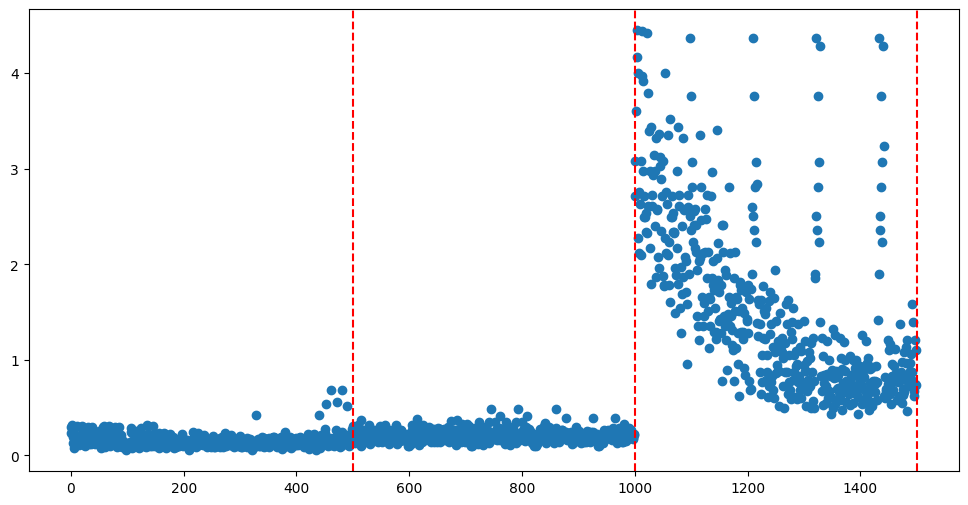

In [105]:
error_df1 = pd.DataFrame({'Reconstruction_error': normal_mse})
error_df2 = pd.DataFrame({'Reconstruction_error': imbalance_mse})
error_df3 = pd.DataFrame({'Reconstruction_error': imgression_mse})
error_df = pd.concat([error_df1, error_df2, error_df3])


plt.figure(figsize = (12,6))
plt.scatter(range(len(error_df)), error_df["Reconstruction_error"])
plt.axvline(x=500*1, color='r', linestyle='--')
plt.axvline(x=500*2, color='r', linestyle='--')
plt.axvline(x=500*3, color='r', linestyle='--')
plt.show()

In [109]:
error_df

,Reconstruction_error
0,0.235667
1,0.299619
2,0.314268
3,0.196954
4,0.128152
...,...
495,0.236596
496,0.168255
497,0.186568
498,0.213474


In [111]:
error_df = error_df.reset_index(drop = True)

error_df

,Reconstruction_error
0,0.235667
1,0.299619
2,0.314268
3,0.196954
4,0.128152
...,...
995,0.236596
996,0.168255
997,0.186568
998,0.213474


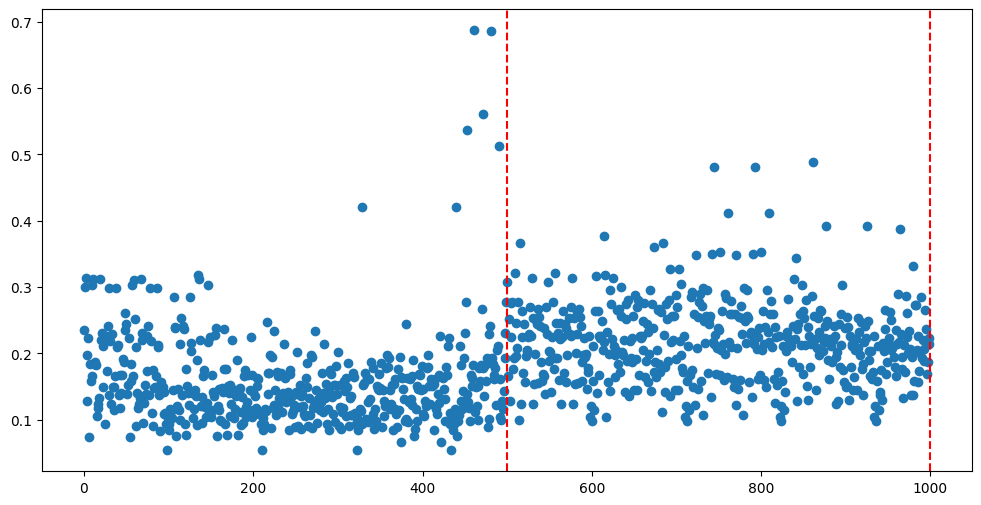

In [112]:
error_df1 = pd.DataFrame({'Reconstruction_error': normal_mse})
error_df2 = pd.DataFrame({'Reconstruction_error': imbalance_mse})
error_df = pd.concat([error_df1, error_df2]).reset_index(drop = True)


plt.figure(figsize = (12,6))
plt.scatter(range(len(error_df)), error_df["Reconstruction_error"])
plt.axvline(x=500*1, color='r', linestyle='--')
plt.axvline(x=500*2, color='r', linestyle='--')
# plt.axvline(x=500*3, color='r', linestyle='--')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

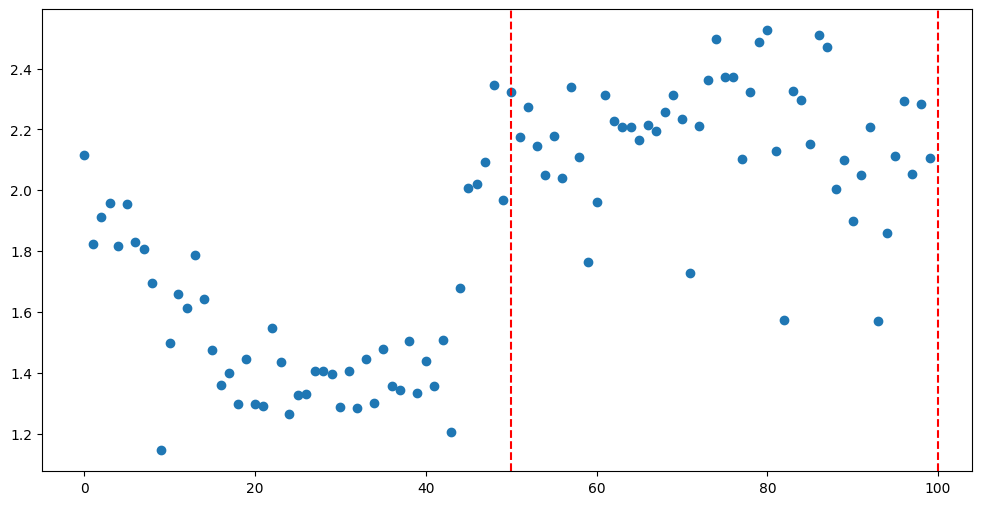

In [108]:
error_df = pd.concat([error_df1, error_df2])

def split_and_sum(df, segment_size=10, column_name='Reconstruction_error'):
    averages = []
    for i in tqdm(range(0, len(df), segment_size)):
        segment = df[column_name].iloc[i:i+segment_size].values
        if len(segment) == segment_size:
            avg = np.sum(segment)
            averages.append(avg)
    
    # 리스트를 데이터프레임으로 변환
    return pd.DataFrame(averages, columns=[f"Reconstruction_error"])

error = split_and_sum(error_df)

plt.figure(figsize = (12,6))
plt.scatter(range(len(error)), error["Reconstruction_error"])
plt.axvline(x=50*1, color='r', linestyle='--')
plt.axvline(x=50*2, color='r', linestyle='--')
# plt.axvline(x=500*3, color='r', linestyle='--')
plt.show()